# Proyecto de Predicción de Churn en Telecomunicaciones

 ## 1.Importaciones y Configuración General

In [1]:
#Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, RocCurveDisplay)


# Cargar datos

In [2]:
# Cargar data
data = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv') #Importar dataset desde el directorio del repositorio
data.head(10)  #Mostrar las primeras 10 filas del dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
print(f"Dataset shape: {data.shape}") # Mostrar las dimensiones del dataset

Dataset shape: (7043, 21)


# Exploratory Data Analysis

In [4]:
# Información básica del dataset
print("Información del dataset:")
print(data.info())
print("\n" + "="*50)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling 

In [5]:
# Valores faltantes
print("\nValores faltantes por columna:")
print(data.isnull().sum())
print("\n" + "="*50)


Valores faltantes por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64



In [6]:
# Convertir 'TotalCharges' a numérico, manejando errores
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

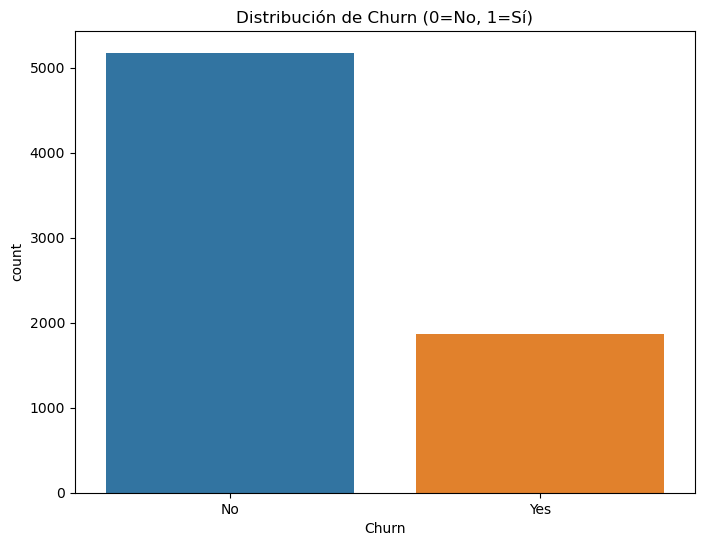

In [7]:
# Análisis de la variable objetivo (Churn)
plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=data)
plt.title('Distribución de Churn (0=No, 1=Sí)')
plt.show()

In [9]:
churn_rate = data['Churn'].value_counts(normalize=True)
print(f"\nTasa de Churn: {churn_rate[1]*100:.2f}%")
print("\n" + "="*50)


Tasa de Churn: 26.54%



C:\Users\Salva\AppData\Local\Temp\ipykernel_23140\545120463.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nTasa de Churn: {churn_rate[1]*100:.2f}%")


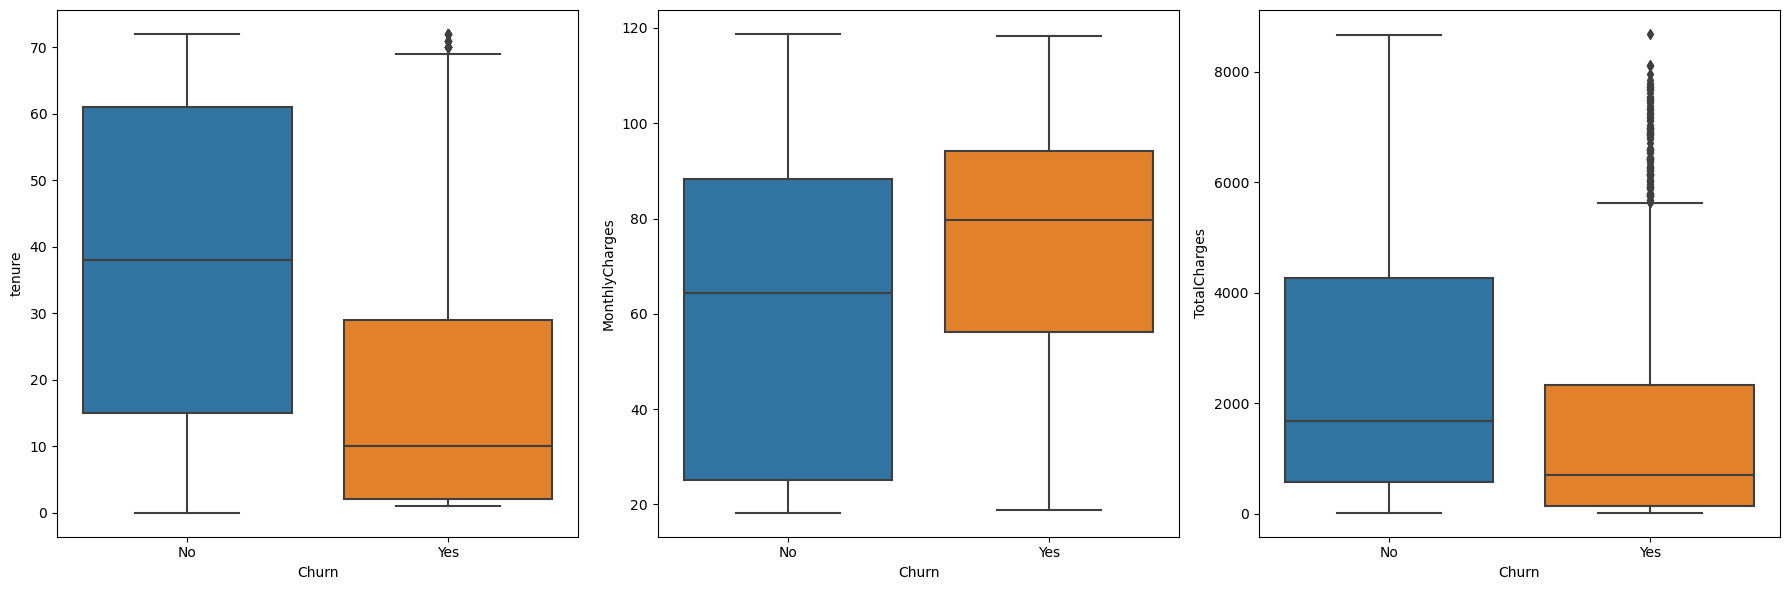

In [10]:
# Relación entre variables clave y Churn
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='Churn', y='tenure', data=data, ax=ax[0])
sns.boxplot(x='Churn', y='MonthlyCharges', data=data, ax=ax[1])
sns.boxplot(x='Churn', y='TotalCharges', data=data, ax=ax[2])
plt.tight_layout()
plt.show()

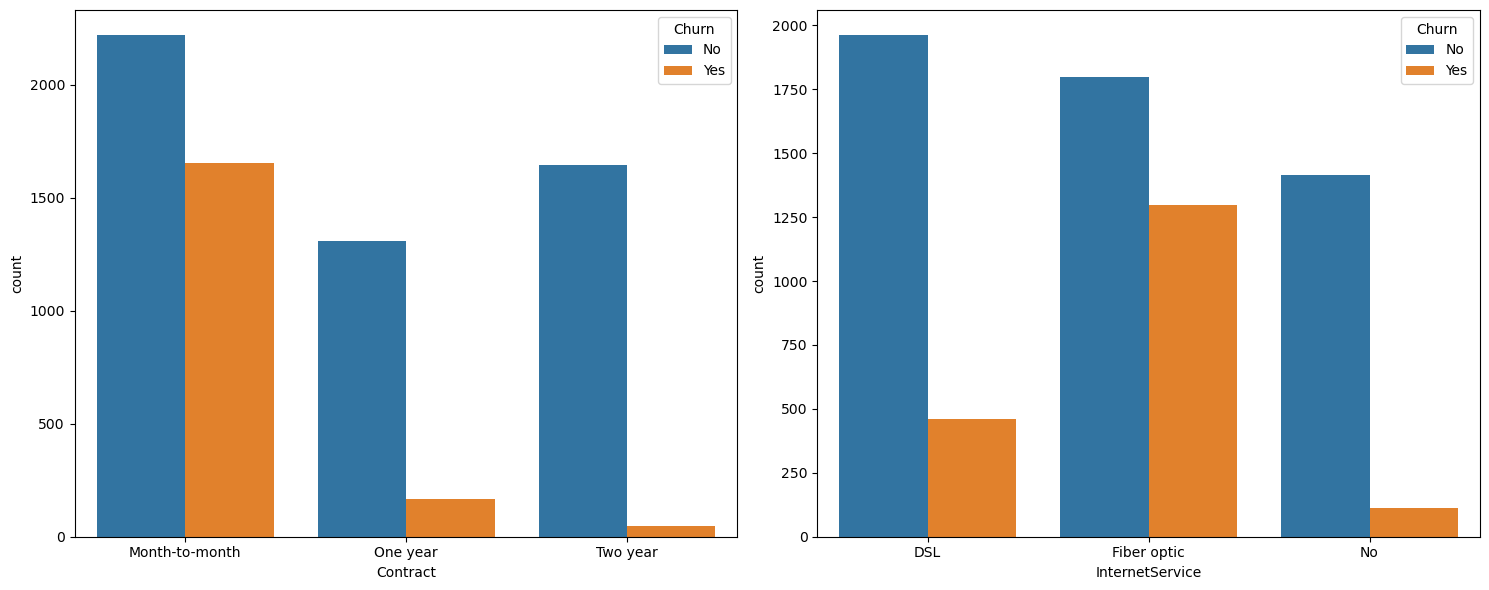

In [11]:
# Análisis de contratos y servicios
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(x='Contract', hue='Churn', data=data, ax=ax[0])
sns.countplot(x='InternetService', hue='Churn', data=data, ax=ax[1])
plt.tight_layout()
plt.show()

# Preprocesamiento

In [12]:
# Eliminar clienteID
data = data.drop('customerID', axis=1)

In [13]:
# Corregir TotalCharges
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [14]:
# Convertir Churn a binario
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

In [15]:
# Identificar columnas por tipo
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [16]:
# Tratamiento de valores faltantes
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

In [17]:
# Crear antigüedad en años
data['tenure_years'] = data['tenure'] / 12

In [18]:
# División estratificada de datos
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)